In [5]:
pip install requests



[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [6]:
import numpy as np
import gpxpy
import json
import gpxpy.gpx
import os
import requests
import folium
import networkx as nx
import osmnx as ox
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import sklearn
from geopy.distance import geodesic



In [7]:
#  Calculating the geographical middle point of the nodes

#We've created a gpx file of a swimming route around "De Omval", it's in the github Assignment 4 folder


gpx_file_url = "https://github.com/JaapdeJ/DATA1/raw/main/Assignment%204/new-2.gpx"
local_file_path = "new-2.gpx"

# Download the GPX file and save it locally
resp = requests.get(gpx_file_url)

if resp.status_code == 200:
    with open(local_file_path, "wb") as f:
        f.write(resp.content)
    print("File downloaded and saved as 'new-2.gpx'")
else:
    print(f"Failed to download the file. Status code: {resp.status_code}")

# Now open the local file for parsing
src = []
with open(local_file_path, 'r', encoding='utf-8') as gpx_file:
    gpx = gpxpy.parse(gpx_file)

    # Iterate through track segments and track points
    for track in gpx.tracks:
        for segment in track.segments:
            for point in segment.points:
                src.append((point.latitude, point.longitude))

# "src" is now a list filled with the coordinates of the GPX file


File downloaded and saved as 'new-2.gpx'


In [8]:
# Separate longitudes and latitudes into separate lists
longitudes = [coord[0] for coord in src]
latitudes = [coord[1] for coord in src]

#Print the separated lists
#print("Longitudes:", longitudes)
#print("Latitudes:", latitudes)

# Calculate the sum of longitudes & latitudes
sum_of_longitudes = sum(longitudes)
sum_of_latitudes = sum(latitudes)
# Calculate the average longitutes & latitudes
average_longitude = sum_of_longitudes / len(longitudes)
average_latitudes = sum_of_latitudes / len(latitudes)

centralized_coordinates = average_longitude, average_latitudes
print("Centralized coordinates are:", centralized_coordinates)

#centralized coordinates are the coordinates of the geographical middle point. 

Centralized coordinates are: (52.34505666008931, 4.911702572185952)


$Question1$

In [9]:
#These are the coordinates of the start and the finish of our swimming route, found in google maps.
startpoint = (52.340556, 4.915507)
endpoint = (52.353764, 4.908897)


(7668866250, 70.7367478625877)
(46307919, 29.230894663047945)
Node found.
Node found.
[7668866250, 7668866256, 8464205579, 4763080503, 7668866234, 4080279096, 7600613997, 8022853275, 46260393, 5438332852, 690751035, 5438332854, 46265835, 5438332848, 46267106, 46268612, 4538188790, 46274467, 299662100, 46275437, 8518477126, 84459183, 84459180, 84459186, 84461467, 8518423316, 84459187, 6927478754, 6927478753, 6927478748, 46286186, 1291631072, 8789135328, 8789135340, 8790385900, 8789135356, 5823758127, 3922156895, 5823170027, 46296920, 46299720, 46303232, 7881454741, 6927485804, 46307919]


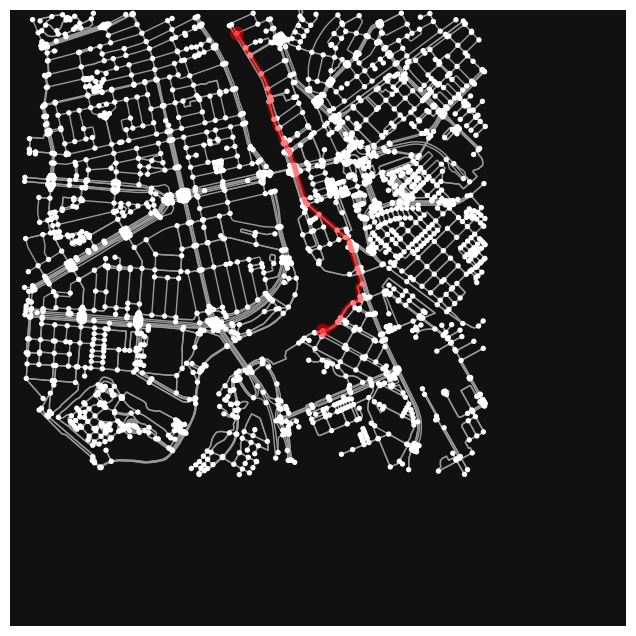

In [10]:
# Creating an area which is roughly around the swimming route to plot
area = ox.graph_from_address('trompenburgstraat, Amsterdam, Netherlands', dist=1200)

#finding the nearest nodes to our start and end point coordinates
node_start = ox.distance.nearest_nodes(area, startpoint[1], startpoint[0], return_dist=True)
node_end = ox.distance.nearest_nodes(area, endpoint[1], endpoint[0], return_dist=True)

#control
print(node_start)
print(node_end)

#creating the shortes path between the nodes
if node_start[0] in area.nodes:
    print("Node found.")
if node_end[0] in area.nodes:
    print("Node found.")
path = ox.shortest_path(area, node_start[0], node_end[0])
print(path)

pt = ox.graph_to_gdfs(area, edges=False).unary_union.centroid
bbox = ox.utils_geo.bbox_from_point(startpoint, dist=1600)
fig, ax = ox.plot_graph_route(area, path, bbox=bbox) 



84459180


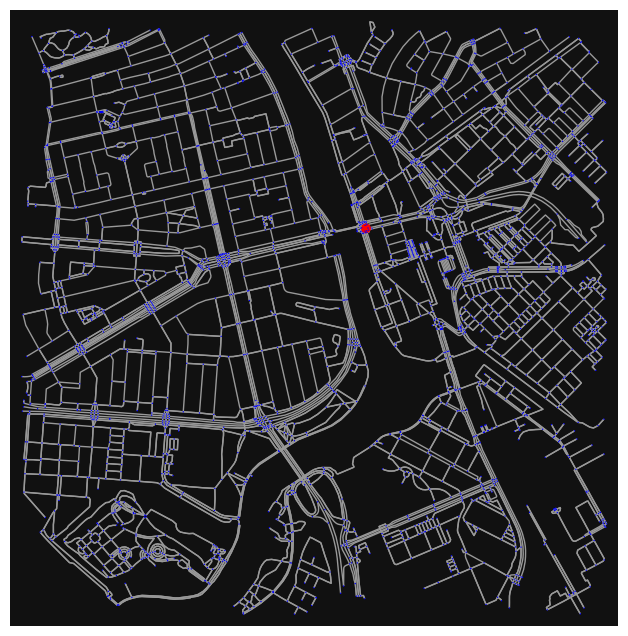

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [11]:
#The central point between the begin- and endpoint is found by dividing the shortes path in two. 
#This is done by finding the middle point of the nodes needed for the shortes path, named "path"
# This is not exactly the middle point but is a very, very close estimation

middle_idx = len(path) // 2
middle_node_id = path[middle_idx]
print(middle_node_id)

node_colors = ['r' if node == middle_node_id else 'b' for node in area.nodes()]
node_size = [50 if node == middle_node_id else 1 for node in area.nodes()]
#Plot the graph with the highlighted node in red and big and others in blue and small

ox.plot_graph(area, node_color=node_colors, node_size=node_size, show=True)

#The central node is highlighted in the following graph: it is the big, red dot on the map. 

$Question 2$

For this question, we use google maps to identify a good location near the centralized node. We found that the building formaly used by the Sissy's is at almost the exact location of the node. This is convenient as the building is empty, but will probably have the amenities to function as a headquarter. 
The address of the location is: Mr.Treublaan 1, 1097 DP Amsterdam
The coordinates of the location are: 52.347774, 4.913855.

In [12]:
#From the coordinates of the sissy's, we'll find the nearest node. 
middle_coordinates = (52.347774, 4.913855)
node_middle = ox.distance.nearest_nodes(area, middle_coordinates[1], middle_coordinates[0], return_dist=True)
print(node_middle)

(8518477118, 10.77498481932049)


$Question 3$

The closest public transportation stops to the starting and finishing line of our event are Sparklerweg station for the starting location, and Wibaustraat station for the finishing line. Both of these are stops for metro lines 51,53 and 54.
To visualize these points we used the Municipality dataset for tram & metro stops by making use of its json format.  We used folium for the map and created markers for the Starting point in blue, the Finishin point in red and the Metro Stations in green, as seen in th code below.


In [13]:
import requests
import json
import folium

# Define the URL of the JSON file
json_url = "https://maps.amsterdam.nl/open_geodata/geojson_lnglat.php?KAARTLAAG=TRAMMETRO_PUNTEN_2022&THEMA=trammetro"

# Send a GET request to the URL and retrieve the JSON data
response = requests.get(json_url)

# Check for a successful response
if response.status_code == 200:
    json_data = response.json()
else:
    print("Failed to retrieve JSON data from the URL.")
    exit()

# Find the points with the names "Spaklerweg" and "Wibautstraat"
desired_names = ["Spaklerweg", "Wibautstraat"]
points_of_interest = []

for feature in json_data["features"]:
    naam = feature["properties"]["Naam"]
    if naam in desired_names:
        points_of_interest.append(feature)

# Verify that the points of interest were found
if len(points_of_interest) < 2:
    print("Not all points of interest were found.")
    exit()


# Create a map centered on one of the points (e.g., "Spaklerweg")
m = folium.Map(location=points_of_interest[0]["geometry"]["coordinates"][::-1], zoom_start=13)

# Add markers for "Spaklerweg" and "Wibautstraat"
for point in points_of_interest:
    naam = point["properties"]["Naam"]
    coordinates = point["geometry"]["coordinates"][::-1]
    folium.Marker(
        location=coordinates,
        popup=f"Location: {naam}",
        icon=folium.Icon(color="green")
    ).add_to(m)

m.save("spaklerweg_wibautstraat_map.html")  # Save the map to an HTML file
m

# Coordinates of the startpoint and endpoint
startpoint = (52.340556, 4.915507)
endpoint = (52.353764, 4.908897)

# Create markers for the startpoint and endpoint
folium.Marker(
    location=startpoint,
    popup="Start Point",
    icon=folium.Icon(color="blue")
).add_to(m)

folium.Marker(
    location=endpoint,
    popup="End Point",
    icon=folium.Icon(color="red")
).add_to(m)

# Save or display the updated map
m.save("spaklerweg_wibautstraat_with_markers.html")
m

From here we wanted to know the maximum capacity of each metro line per hour.  
To do this, we looked into the information available about the Metro models capacity (Ovopro, 2012)(GVB, nd)(Wikipedia, 2023a) (Wikipedia, 2023b). Since some metro lines have more than one model of carriages in use, for the purpose of this exercise we assumed the following:

M51 line - train model M4 with 66 siting spots + 184 standing spots per carriage; 1 train = 3 carriages   (Wikipedia, 2023a)
M53 line - train model M5 with 174 siting spots + 786 standing spots (Wikipedia, 2023b)
M54 line - train model M5 with 174 siting spots + 786 standing spots (Wikipedia, 2023b)

Since a specific day of the week was not suggested, we also assumed the event takes place during the middle of the day in the weekend, when the Metro frequency on this location is 5 times per hour.

As shown by the code below the maximum capacity for local public transportation at each station is of 26700 passengers per hour.

In [14]:
#How many people can be transported within an hour?
M51_max_capacity = 3*(66+184)
M51_frequency = 5
M53_max_capacity  = 174+786
M53_frequency = 5
M54_max_capacity  = 174+786
M54_frequency = 5


one_way_capacity = (M51_max_capacity*M51_frequency) + (M53_max_capacity*M53_frequency) + (M54_max_capacity*M54_frequency)
total_capacity = 2 * one_way_capacity
print(total_capacity,"passengers per hour at each station")

26700 passengers per hour at each station


$Question 4$

The lines of metro 51,53 and 54 can be visualized  in the GVB platform (GVB, n.d.-a). They all run from Amsterdam Centraal station towards: 
 51 - Central Station - Isolatorweg 
 53 - Central Station - Gasperplaas 
 54 - Central Station - Gein 

 We tried to visualize these in the previous map with the code below but noticed that the dataset from the municipality does not have each line as an individual element (it is instead built based on individual stops). Because of this we could not visualize the whole line route in python

In [15]:
import requests

# Define the URL of the JSON file
json_url = "https://maps.amsterdam.nl/open_geodata/geojson_lnglat.php?KAARTLAAG=TRAMMETRO_PUNTEN_2022&THEMA=trammetro"

# Send a GET request to the URL and retrieve the JSON data
response = requests.get(json_url)

# Check for a successful response
if response.status_code == 200:
    json_data = response.json()
else:
    print("Failed to retrieve JSON data from the URL.")
    exit()

# The JSON data is now in the json_data variable.

desired_routes = ["51", "53", "54"]

# Initialize an empty list to store the filtered features
filtered_features = []

# Iterate through the features and filter by route number
for feature in json_data["features"]:
    route_number = feature["properties"]["Lijn"]
    if route_number in desired_routes:
        filtered_features.append(feature)

# The filtered features are now in the filtered_features list.

import folium
from folium import FeatureGroup, LayerControl

m = folium.Map(location=[52.3399730644161, 4.920684561554927], zoom_start=15)  # Set initial center and zoom level

for feature in filtered_features:
    route_number = feature["properties"]["Lijn"]
    coordinates = feature["geometry"]["coordinates"]

    # Create a FeatureGroup for each route
    route_group = FeatureGroup(name=f"Lijn {51|53|54}")
    
    # Create a Polyline to represent the route
    polyline = folium.PolyLine(
        locations=coordinates,
        color='red',  # Customize line color
        weight=3,      # Customize line weight
        opacity=0.7,   # Customize line opacity
        popup=f"Lijn {51|53|54}"  # Customize the popup content
    ).add_to(route_group)

    # Add the FeatureGroup to the map
    route_group.add_to(m)

# Add a LayerControl to allow toggling the visibility of routes
LayerControl().add_to(m)
 

# Add a LayerControl to allow toggling the visibility of routes
LayerControl().add_to(m)

print(filtered_features)
m.save("amsterdam_routes_map.html")  # Save the map to an HTML file
m


[]


$Question 5$

The relevant centrality that is used is closeness centrality. This type of centrality mesasures how quickly a specific node can reach all other nodes in the network. The focus is on efficiency of movement. This means that it is a great measurement for physical centrality, as it shows how quickly other parts of the network can be reached. 

In [16]:
#we have the start node, end node and middle node. These are used to calculate the centrality.
print(node_start)
print(node_middle)
print(node_end)

start_centrality = nx.closeness_centrality(area, u=node_start[0])
middle_centrality = nx.closeness_centrality(area, u=node_middle[0])
end_centrality = nx.closeness_centrality(area, u=node_end[0])

print("the centrality of the start point is:", start_centrality)
print("the centrality of the middle point is:", middle_centrality)
print("the centrality of the end point is:", end_centrality)

(7668866250, 70.7367478625877)
(8518477118, 10.77498481932049)
(46307919, 29.230894663047945)
the centrality of the start point is: 0.03712610378619268
the centrality of the middle point is: 0.040519170717267405
the centrality of the end point is: 0.03126284917726265


$Question 6$

In [17]:
#First we calculate the distance an average person walks within 10 minutes rounded up to 100 meters. On average, we walk at around 5kph. 
time = 60*10
speed = 5 / 3.6
distance = (int((time * speed)/100))*100
print("On average, a person walks", distance, "meters in 10 minutes" )



On average, a person walks 800 meters in 10 minutes


In [18]:
print(endpoint)

(52.353764, 4.908897)


We extract data from the database FUNCTIEKAART form the municipality of Amsterdam. It contains all the non-residential addresses of Amsterdam with their corresponding function and coordinates, and more information. 

From it, we extract the addresses that have the function of HORECA. Then, we extract the elements that are within a radius of 750 meters from our endpoint. This is ofcourse not the same as walking 800 meters, but is a close estimation. We store these elements in a new dataframe, called close_horeca.  

In [19]:
# Configure pandas to display all columns and rows without truncation
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_rows', None)

# Configure pandas to display all rows without truncation
pd.set_option('display.max_rows', None)

# Load your dataset and specify the delimiter
gpx_file_url = "https://github.com/JaapdeJ/DATA1/raw/main/Assignment%204/FUNCTIEKAART.csv"
local_file_path = "FUNTIEKAART.csv"

# Download the GPX file and save it locally
resp = requests.get(gpx_file_url)

if resp.status_code == 200:
    with open(local_file_path, "wb") as f:
        f.write(resp.content)
    print("File downloaded and saved as 'FUNCTIEKAART.csv'")
else:
    print(f"Failed to download the file. Status code: {resp.status_code}")

df = pd.read_csv(local_file_path, delimiter=';') #JAAP, HIER MOET EEN ANDER PAD NAAR DE FILE 

# Filter for horeca locations
horeca_df = df[df['Functie'] == 'Horeca']

# Function to extract coordinates from the 'WKT_LAT_LNG' column
def extract_coordinates(row):
    # Extract coordinates without the extra characters at the end
    coordinates_str = row['WKT_LAT_LNG'].split('(')[1].rstrip(')').split()
    return (float(coordinates_str[0]), float(coordinates_str[1]))

# Make a copy of the DataFrame to avoid the warning
horeca_df = horeca_df.copy()

# Calculate distances and add a new 'Distance' column
horeca_df['Coordinates'] = horeca_df.apply(extract_coordinates, axis=1)
horeca_df['Distance'] = horeca_df['Coordinates'].apply(lambda coords: geodesic(endpoint, coords).meters)

# Filter based on distance (750m or less)
close_horeca = horeca_df[horeca_df['Distance'] <= 750]  # people walk up to 750 meters

# Count the number of horeca found
num_horeca_found = len(close_horeca)

# Print the result
print(f"The number of horeca we've found within 800 meters distance from the end point is {num_horeca_found}")

print("Here is the list of the found horecas:")

# Print selected columns for rows that meet the criteria
print(close_horeca[['OBJECTNUMMER', 'Adres', 'Gebruiksdoel', 'Objectsoort', "Coordinates", "Distance"]])



File downloaded and saved as 'FUNCTIEKAART.csv'
The number of horeca we've found within 800 meters distance from the end point is 166
Here is the list of the found horecas:
       OBJECTNUMMER                                   Adres                      Gebruiksdoel                       Objectsoort              Coordinates    Distance
4                 5                       Afrikanerplein 14                bijeenkomstfunctie                        Restaurant  (52.3526614, 4.9165993)  538.956047
508             509                        Amsteldijk 132/H                bijeenkomstfunctie                         Cafetaria  (52.3475067, 4.9108862)  709.345418
525             526                           Amsteldijk 25                bijeenkomstfunctie                        Restaurant  (52.3568457, 4.9044155)  459.152259
532             533                           Amsteldijk 35                bijeenkomstfunctie                  Kantoor|Cafe/bar  (52.3557515, 4.9049852)  346.332981
53

Next, we extract the coordinates column and store the elements in a separate list. With this list, we'll later plot the horeca places on a map using Folium. 

In [20]:
# Extract the "Coordinates" column as a list of tuples
coordinates_list = close_horeca["Coordinates"].tolist()

# Convert the tuples to a list of integers
int_coordinates_list = [(int(coord[0] * 10**6), int(coord[1] * 10**6)) for coord in coordinates_list]

# Print the resulting list of integer coordinates to control if it works 
print(int_coordinates_list)
print(int_coordinates_list[0])
print(len(int_coordinates_list))

[(52352661, 4916599), (52347506, 4910886), (52356845, 4904415), (52355751, 4904985), (52355061, 4905506), (52354300, 4906233), (52354255, 4906263), (52348634, 4903154), (52359856, 4911077), (52359645, 4912150), (52359301, 4913813), (52359213, 4914240), (52357150, 4917652), (52357069, 4917712), (52356908, 4917831), (52356749, 4918581), (52356711, 4918039), (52356487, 4918305), (52357644, 4917500), (52356642, 4909819), (52359852, 4912310), (52358462, 4912985), (52358094, 4913209), (52357852, 4913373), (52357780, 4913447), (52357601, 4913567), (52354371, 4899261), (52354707, 4900314), (52354871, 4900796), (52355081, 4901499), (52355108, 4901586), (52355226, 4901952), (52355572, 4903035), (52355718, 4903517), (52356028, 4904468), (52355076, 4902614), (52356667, 4911522), (52356695, 4911653), (52356767, 4911873), (52356777, 4911917), (52356804, 4912005), (52356904, 4912429), (52357219, 4914584), (52357151, 4913425), (52357242, 4913776), (52355735, 4907789), (52356155, 4909443), (52356183, 4

Now, we plot the elements on a map using Folium. A circle of 750 meters around our endpoint is showed and within are the cafes and restaurants

In [21]:
import folium

# Create a map centered around a location (e.g., Amsterdam)
m = folium.Map(location=[52.350060, 4.910835], zoom_start=14)

# Loop through the int_coordinates_list and add markers for each set of coordinates
for coord in int_coordinates_list:
    lat, lon = coord
    folium.Marker([lat / 10**6, lon / 10**6]).add_to(m)

folium.Circle(location=endpoint, radius=750, color="red", fill=True, fill_opacity=0.2).add_to(m)


# Save the map as an HTML file or display it in a Jupyter Notebook
m.save("coordinates_map.html")


In [22]:
m

References:

GVB. (n.d.-a). Lijnen | GVB. Reisinfo.gvb.nl. Retrieved October 20, 2023, 
from https://reisinfo.gvb.nl/nl/lijnen

GVB. (n.d.-b). Onze metro’s. Over GVB. Retrieved October 19, 2023, 
from https://over.gvb.nl/ov-in-amsterdam/voer-en-vaartuigen/metro-in-cijfers/

Ovopro. (2012, January 5). GVB verwacht eerste nieuwe metro’s type M5 in maart. OVPro.nl. 
https://www.ovpro.nl/metro/2012/01/05/gvb-verwacht-eerste-nieuwe-metros-type-m5-in-maart/?gdpr=deny

Wikipedia. (2023a, August 8). Metro-/sneltrammaterieel M4/S3. Wikipedia. 
https://nl.wikipedia.org/wiki/Metro-/sneltrammaterieel_M4/S3

Wikipedia. (2023b, September 10). Metromaterieel M5. Wikipedia. 
https://nl.wikipedia.org/wiki/Metromaterieel_M5